In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
import cv2
import sys
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os
from sklearn.externals import joblib
from skimage.feature import hog

In [2]:
clf = joblib.load('person_final_hard.pkl')
test_path = "testdataset"
testData = []
testLabels = []

In [3]:
# get the test labels
train_labels = os.listdir(test_path)

In [4]:
%%time
# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(test_path, training_name)

    # get the current training label
    current_label = training_name
    images_per_class = len(os.listdir(dir))
    num = 0
    count = 0
    if(current_label == 'neg'):
        print ("Processing Negative images")
        for x in range(1,images_per_class+1):
            file = dir + "/" + str(x) + ".jpg"
            img = cv2.imread(file)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            fd = hog(gray,orientations=9,pixels_per_cell=(6,6),cells_per_block=(2,2),block_norm="L1",transform_sqrt=True)
            testData.append(fd)
            testLabels.append(0)
            count = count + 1
            num = num + 1
            sys.stdout.write("\r" + "Images Done: " + str((num/4553.0)*100) + "\t negatives: " + str(count))
            sys.stdout.flush()
        print ("\n[STATUS] processed folder: {}".format(current_label))
    elif(current_label == 'pos'):
        print ("Processing Positive images")
        for x in range(1,images_per_class+1):
            file = dir + "/" + str(x) + ".jpg"
            img = cv2.imread(file)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            fd = hog(gray,orientations=9,pixels_per_cell=(6,6),cells_per_block=(2,2),block_norm="L1",transform_sqrt=True)
            testData.append(fd)
            testLabels.append(1)
            count = count + 1
            num = num + 1
            sys.stdout.write("\r" + "Images Done: " + str((num/958.0)*100) + "\t positives: " + str(count))
            sys.stdout.flush()
        print ("\n[STATUS] processed folder: {}".format(current_label))
            

print ("[STATUS] completed Positive and Negative Feature Extraction...")

Processing Negative images
Images Done: 100.0	 negatives: 4553atives: 45523
[STATUS] processed folder: neg
Processing Positive images
Images Done: 100.0	 positives: 958sitives: 9573
[STATUS] processed folder: pos
[STATUS] completed Positive and Negative Feature Extraction...
CPU times: user 26.8 s, sys: 1.9 s, total: 28.7 s
Wall time: 30.3 s


In [5]:
prediction_result = clf.predict(testData)
score = accuracy_score(np.asarray(testLabels), prediction_result)

In [6]:
decision = clf.decision_function(testData)
average_precision = average_precision_score(testLabels, decision)
print('\nAverage precision-recall score: {0:0.2f}'.format(
      average_precision))
print("\nClassification Report\n")
print(classification_report(testLabels, prediction_result))
print("Accuracy:" +str(score)+'\n')
print("Confusion Matrix")
cmx = confusion_matrix(testLabels, prediction_result, labels=[0,1])
df = pd.DataFrame(cmx, columns=[0,1], index=[0,1])
df.columns.name = 'prediction'
df.index.name = 'label'
df


Average precision-recall score: 0.99

Classification Report

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4553
           1       0.86      0.98      0.91       958

   micro avg       0.97      0.97      0.97      5511
   macro avg       0.93      0.97      0.95      5511
weighted avg       0.97      0.97      0.97      5511

Accuracy:0.9682453275267646

Confusion Matrix


prediction,0,1
label,,
0,4396,157
1,18,940


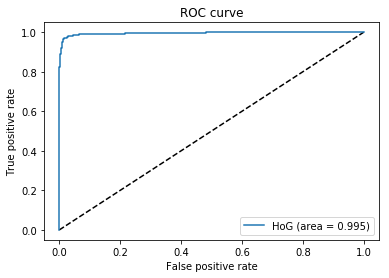

In [7]:
fpr_svm, tpr_svm, thresholds_svm = roc_curve(testLabels, decision)
fpr_, tpr_, thresholds_ = roc_curve(testLabels, decision)
auc_svm = auc(fpr_svm, tpr_svm)
auc_ = auc(fpr_, tpr_)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_svm, tpr_svm, label='class 0 (area = {:.3f})'.format(auc_svm))
plt.plot(fpr_, tpr_, label='HoG (area = {:.3f})'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('ROC.png')
plt.show()

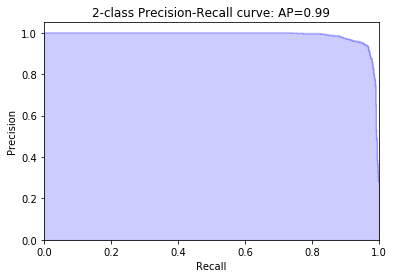

In [8]:
precision, recall, _ = precision_recall_curve(testLabels, decision)
# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()